# Домашнее задание 3. TensorFlow.

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data()

In [3]:
with np.printoptions(precision=3, suppress=True):
    print('X_train:', X_train[:5, :])
    print('y_train:', y_train[:5])

X_train: [[  1.232   0.      8.14    0.      0.538   6.142  91.7     3.977   4.
  307.     21.    396.9    18.72 ]
 [  0.022  82.5     2.03    0.      0.415   7.61   15.7     6.27    2.
  348.     14.7   395.38    3.11 ]
 [  4.898   0.     18.1     0.      0.631   4.97  100.      1.333  24.
  666.     20.2   375.52    3.26 ]
 [  0.04    0.      5.19    0.      0.515   6.037  34.5     5.985   5.
  224.     20.2   396.9     8.01 ]
 [  3.693   0.     18.1     0.      0.713   6.376  88.4     2.567  24.
  666.     20.2   391.43   14.65 ]]
y_train: [15.2 42.3 50.  21.1 17.7]


In [4]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

In [5]:
def build_nn(n_layers, n_neurons, activation, normalizer, optimizer, loss, metrics,
             name_to_save_weights=None, name_to_load_weights=None):

    model = Sequential(
        [normalizer] + \
        [Dense(n_neurons[i], activation=activation[i]) if i != 0 else \
         Dense(n_neurons[i], activation=activation[i], input_shape=(13,)) \
         for i in range(n_layers)]
         )
    
    if name_to_save_weights:
        model.save_weights(name_to_save_weights)
    
    if name_to_load_weights:
        model.load_weights(name_to_load_weights)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)
    
    return model

In [6]:
n_layers = 2
n_neurons = [32, 1]
activation = ['relu', 'linear']
optimizer = 'adam'
loss = 'mse'
metrics = [tf.keras.metrics.RootMeanSquaredError()]

model = build_nn(n_layers, n_neurons, activation, normalizer, optimizer, loss, metrics)

In [7]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=0)

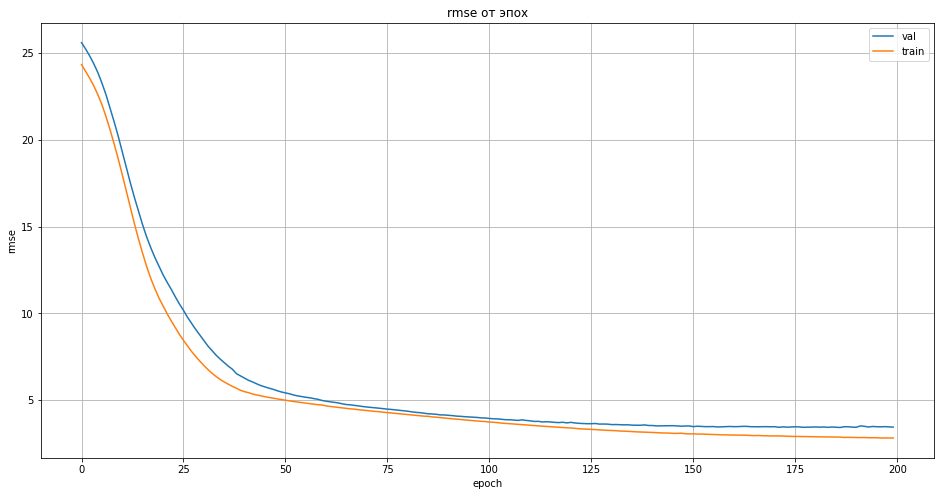

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(history.history['val_root_mean_squared_error'] ,label='val')
plt.plot(history.history['root_mean_squared_error'] ,label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.title('rmse от эпох')
plt.grid()
plt.show()

In [9]:
y_pred = model.predict(X_test[:10], verbose=0)

In [10]:
with np.printoptions(precision=1, suppress=True):
    print('y_pred:', y_pred.reshape((10,)))
    print('y_test:', y_test[:10])

y_pred: [ 7.5 18.5 21.5 36.  24.8 18.6 27.3 22.  19.6 22.3]
y_test: [ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


In [11]:
model.evaluate(X_test, y_test, verbose=0)

[24.694494247436523, 4.969355583190918]

Посчитаем несколько 2хслойных моделей с разных количеством нейронов.

In [12]:
results = []

In [13]:
n_layers = 2
neuron_numbers = (50, 60, 70, 80, 90, 100)
activation = ('relu', 'linear')

optimizer = 'adam'
loss = 'mse'
metrics = (tf.keras.metrics.RootMeanSquaredError())

epochs = 200
batch_size = 16
val_split = 0.2

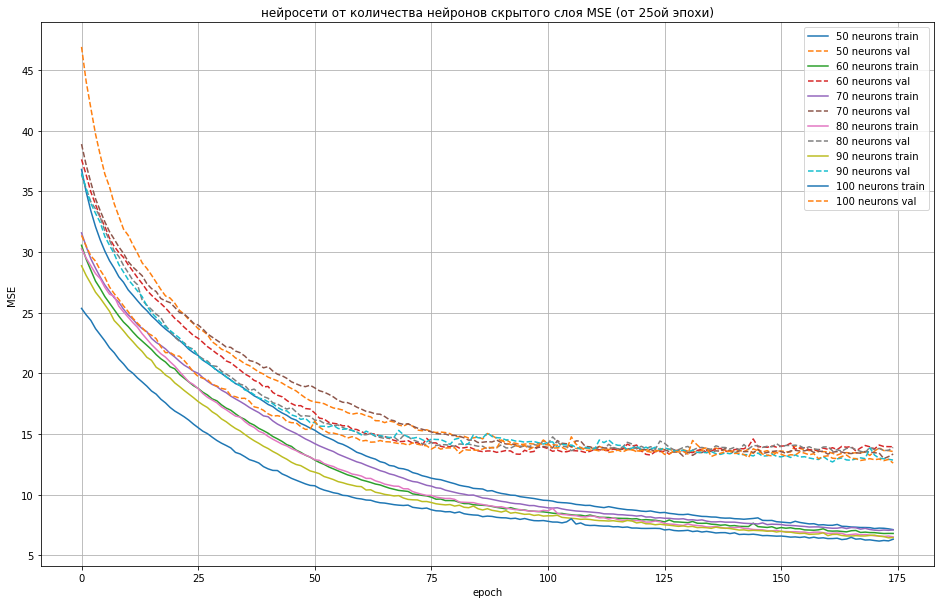

In [14]:
plt.figure(figsize=(16, 10))

for n_num in neuron_numbers:

    model = build_nn(n_layers, (n_num, 1), activation, normalizer, 
                     optimizer, loss, metrics)

    lh = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=val_split,
                   verbose=0)
    
    res_test = model.evaluate(X_test, y_test, verbose=0)

    results.append({'model': f'2 layers {n_num} neurons',
                    'sample': 'train',
                    'loss': lh.history['loss'][-1],
                    'rmse': lh.history['root_mean_squared_error'][-1]})
    results.append({'model': f'2 layers {n_num} neurons',
                    'sample': 'validate',
                    'loss': lh.history['val_loss'][-1],
                    'rmse': lh.history['val_root_mean_squared_error'][-1]})
    results.append({'model': f'2 layers {n_num} neurons',
                    'sample': 'test',
                    'loss': res_test[0],
                    'rmse': res_test[1]})

    plt.plot(lh.history['loss'][25:], '-', label=f'{n_num} neurons'+' train')
    plt.plot(lh.history['val_loss'][25:], '--', label=f'{n_num} neurons'+' val')
plt.legend()
plt.grid('On')

plt.title('нейросети от количества нейронов скрытого слоя MSE (от 25ой эпохи)')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

Также построим сети и изучим зависимость их точности от количества скрытых слоев.

In [15]:
layers_numbers = (2, 3, 5)
neuron_numbers = [(100, 1),
                  (70, 60, 1),
                  (60, 50, 40, 30, 1)]

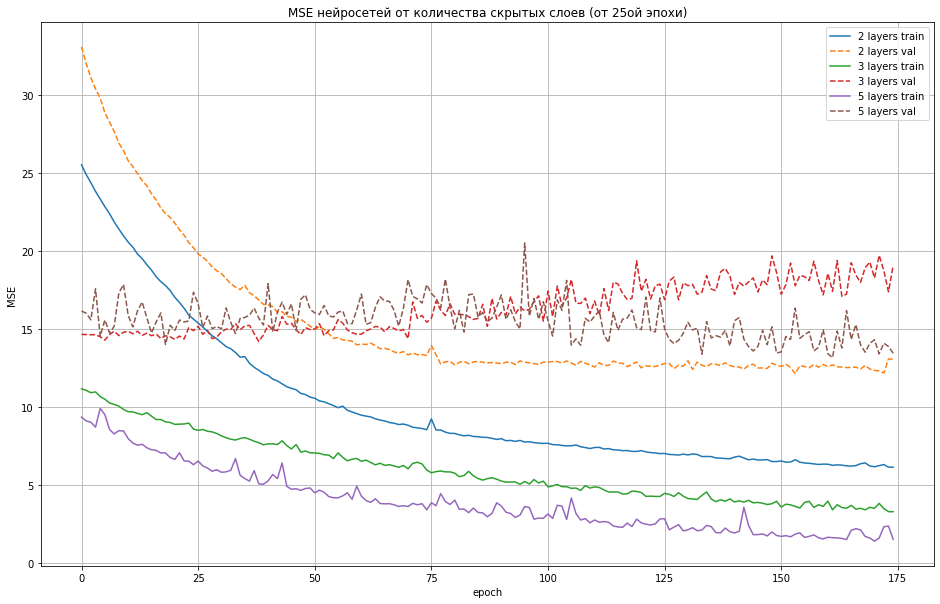

In [16]:
plt.figure(figsize=(16, 10))

for i in range(len(layers_numbers)):

    activation = (layers_numbers[i] - 1) * ['relu'] + ['linear']

    model = build_nn(layers_numbers[i], neuron_numbers[i], activation, normalizer, 
                     optimizer, loss, metrics)

    lh = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=val_split,
                   verbose=0)
    
    res_test = model.evaluate(X_test, y_test, verbose=0)

    results.append({'model': f'{layers_numbers[i]} layers',
                    'sample': 'train',
                    'loss': lh.history['loss'][-1],
                    'rmse': lh.history['root_mean_squared_error'][-1]})
    results.append({'model': f'{layers_numbers[i]} layers',
                    'sample': 'validate',
                    'loss': lh.history['val_loss'][-1],
                    'rmse': lh.history['val_root_mean_squared_error'][-1]})
    results.append({'model': f'{layers_numbers[i]} layers',
                    'sample': 'test',
                    'loss': res_test[0],
                    'rmse': res_test[1]})

    plt.plot(lh.history['loss'][25:], '-', label=f'{layers_numbers[i]} layers'+' train')
    plt.plot(lh.history['val_loss'][25:], '--', label=f'{layers_numbers[i]} layers'+' val')
plt.legend()
plt.grid('On')

plt.title('MSE нейросетей от количества скрытых слоев (от 25ой эпохи)')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

Теперь посмотрим на результаты разных оптимизаторов.

In [17]:
layers_numbers = 5
neuron_numbers = (60, 50, 40, 30, 1)
activation = ['relu', 'relu', 'relu', 'relu', 'linear']

optimizers = ['SGD','RMSProp','adam','NAdam']
loss = 'mse'
metrics = [tf.keras.metrics.RootMeanSquaredError()]

epochs = 200
batch_size = 16
val_split = 0.2

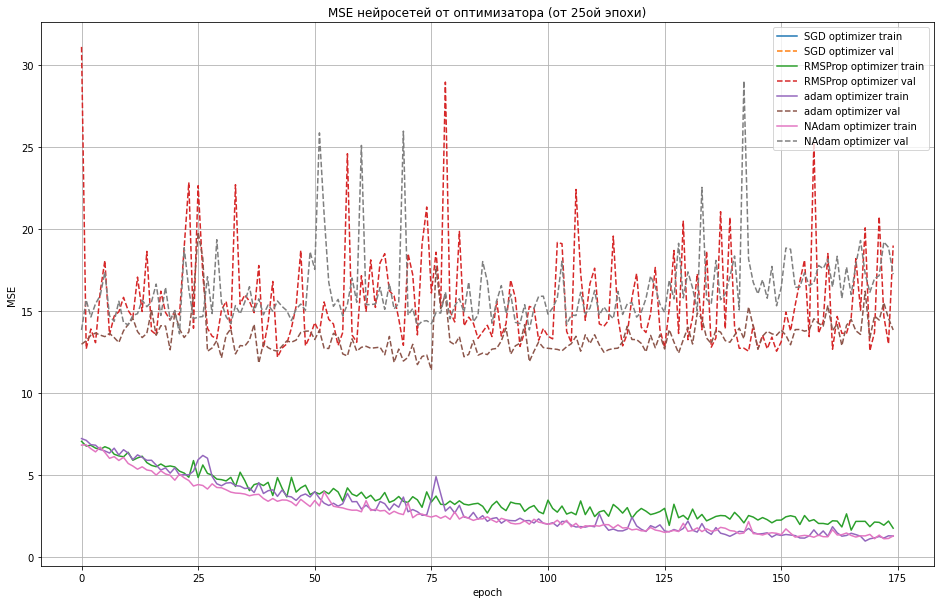

In [18]:
plt.figure(figsize=(16, 10))

for i in range(len(optimizers)):

    if i != 0:
        model = build_nn(layers_numbers, neuron_numbers, activation, normalizer, 
                         optimizers[i], loss, metrics,
                         name_to_load_weights='model_weights.h5')
    else:
        model = build_nn(layers_numbers, neuron_numbers, activation, normalizer, 
                         optimizers[i], loss, metrics,
                         name_to_save_weights='model_weights.h5')

    lh = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=val_split,
                   verbose=0)
    
    res_test = model.evaluate(X_test, y_test, verbose=0)

    results.append({'model': f'{optimizers[i]} optimizer',
                    'sample': 'train',
                    'loss': lh.history['loss'][-1],
                    'rmse': lh.history['root_mean_squared_error'][-1]})
    results.append({'model': f'{optimizers[i]} optimizer',
                    'sample': 'validate',
                    'loss': lh.history['val_loss'][-1],
                    'rmse': lh.history['val_root_mean_squared_error'][-1]})
    results.append({'model': f'{optimizers[i]} optimizer',
                    'sample': 'test',
                    'loss': res_test[0],
                    'rmse': res_test[1]})

    plt.plot(lh.history['loss'][25:], '-', label=f'{optimizers[i]} optimizer'+' train')
    plt.plot(lh.history['val_loss'][25:], '--', label=f'{optimizers[i]} optimizer'+' val')
plt.legend()
plt.grid('On')

plt.title('MSE нейросетей от оптимизатора (от 25ой эпохи)')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [19]:
df = pd.DataFrame(results)
df = df.set_index(['model'])

In [20]:
df[df['sample'] == 'test'].sort_values(by='loss', ascending=True)

,sample,loss,rmse
model,,,
5 layers,test,14.664461,3.829421
3 layers,test,17.596689,4.194841
adam optimizer,test,18.373091,4.286384
2 layers,test,20.839462,4.565026
2 layers 100 neurons,test,21.388737,4.624796
2 layers 90 neurons,test,21.629797,4.650784
2 layers 50 neurons,test,22.451107,4.738260
2 layers 80 neurons,test,22.593231,4.753234
2 layers 60 neurons,test,22.717575,4.766296
